In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [6]:
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('/pets',
                              transform=transform,
                              target_transform=target_transform,
                              target_types='segmentation', download=True)
valid_dataset = OxfordIIITPet('pets',
                              transform=transform,
                              split='test',
                              target_transform=target_transform, target_types='segmentation', download=True)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

subset = Subset(valid_dataset, idx)
valid_loader = DataLoader(subset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
torch.cuda.is_available()

True

In [9]:
#!g1.1
from tqdm import tqdm
from torch import nn

def train(train_loader, model:nn.Module, loss_fn, optimizer) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to('cuda'), y.squeeze(1).to('cuda')

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [10]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader, loss_fn) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to('cuda'), y.squeeze(1).to('cuda')

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [11]:
#!g1.1
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [12]:
#!g1.1
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [13]:
import torch.nn as nn


def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        
        base_channels = 32
        base_channels_in = 32
        base_channels_out = 32
        
        self.down1 = conv_plus_conv(3, base_channels) #3x32
        self.down2 = conv_plus_conv(base_channels_in, base_channels_out * 2) 
        self.down3 = conv_plus_conv(base_channels_in*2, base_channels_out * 4) 
        self.down4 = conv_plus_conv(base_channels_in*4, base_channels_out * 8) 
        self.down5 = conv_plus_conv(base_channels_in*8, base_channels_out * 16) 

        self.up1 = conv_plus_conv(base_channels_in * 2, base_channels_out) 
        self.up2 = conv_plus_conv(base_channels_in * 4, base_channels_out) 
        self.up3 = conv_plus_conv(base_channels_in * 8, base_channels_out * 2) 
        self.up4 = conv_plus_conv(base_channels_in * 16, base_channels_out * 4) 
        self.up5 = conv_plus_conv(base_channels_in * 32, base_channels_out * 8) 

        self.bottleneck = conv_plus_conv(base_channels_in * 16, base_channels_out * 16) 

        self.out = nn.Conv2d(in_channels=base_channels_in, out_channels=3, kernel_size=1) 

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  
        x = self.downsample(residual1) #128
#         print(f"down1 {x.shape}")

        residual2 = self.down2(x)  
        x = self.downsample(residual2)  #64
#         print(f"down2 {x.shape}")
        
        residual3 = self.down3(x) 
        x = self.downsample(residual3) #32
#         print(f"down3 {x.shape}")
        
        residual4 = self.down4(x) 
        x = self.downsample(residual4) #16
#         print(f"down4 {x.shape}")
        
        residual5 = self.down5(x) 
        x = self.downsample(residual5) #8
#         print(f"down5 {x.shape}")
        
        # LATENT SPACE DIMENSION DIM = N // 4
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)
#         print(f"bottleneck {x.shape}")
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 4
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x,residual5),dim=1)
        x = self.up5(x)
#         print(f"up5 {x.shape}")
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x,residual4),dim=1)
        x = self.up4(x)
#         print(f"up4 {x.shape}")
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x,residual3),dim=1)
        x = self.up3(x)
#         print(f"up3 {x.shape}")
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 2, N // 2, base_channels * 2)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 2, N // 2, base_channels * 4)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, base_channels * 4) -> (N // 2, N // 2, base_channels)
#         print(f"up2 {x.shape}")
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N, N, base_channels)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)
#         print(f"up1 {x.shape}")
        
        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

In [14]:
from torch.optim import Adam

model = UNET().to("cuda")

optimizer = Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

In [17]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(train_loader,model,loss_fn, optimizer)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))
        
        if valid_accuracy >=0.88:
            break

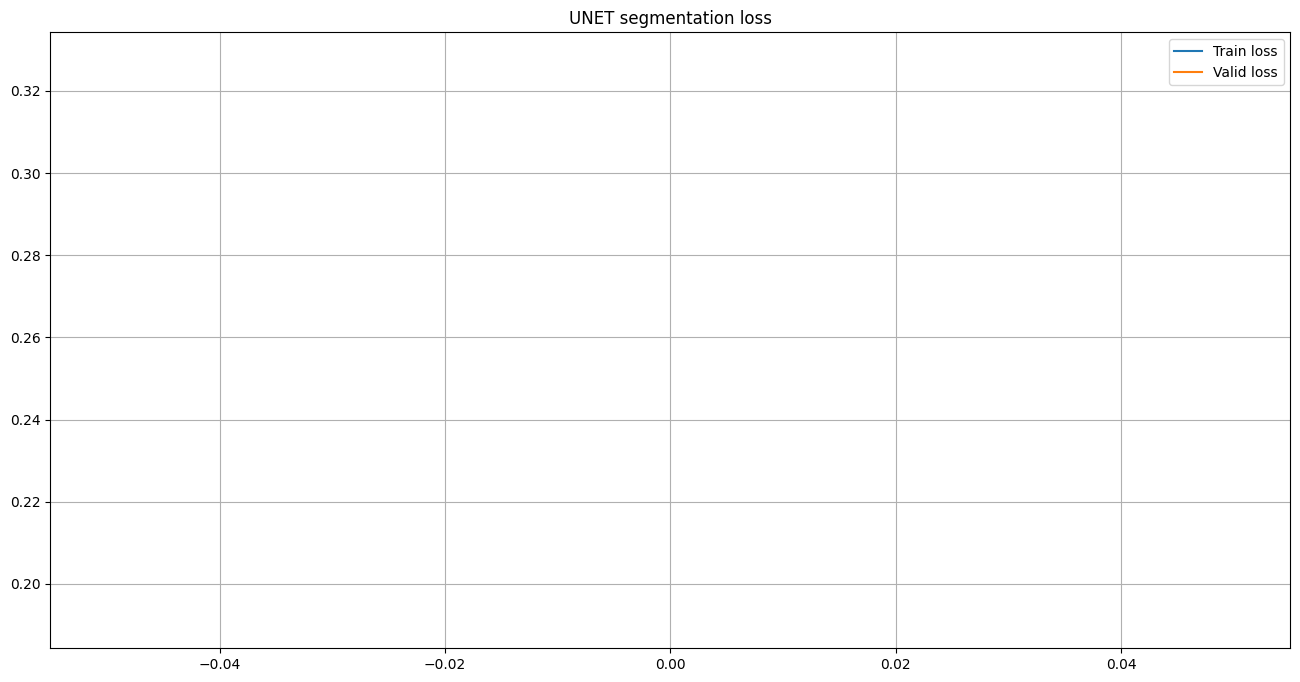

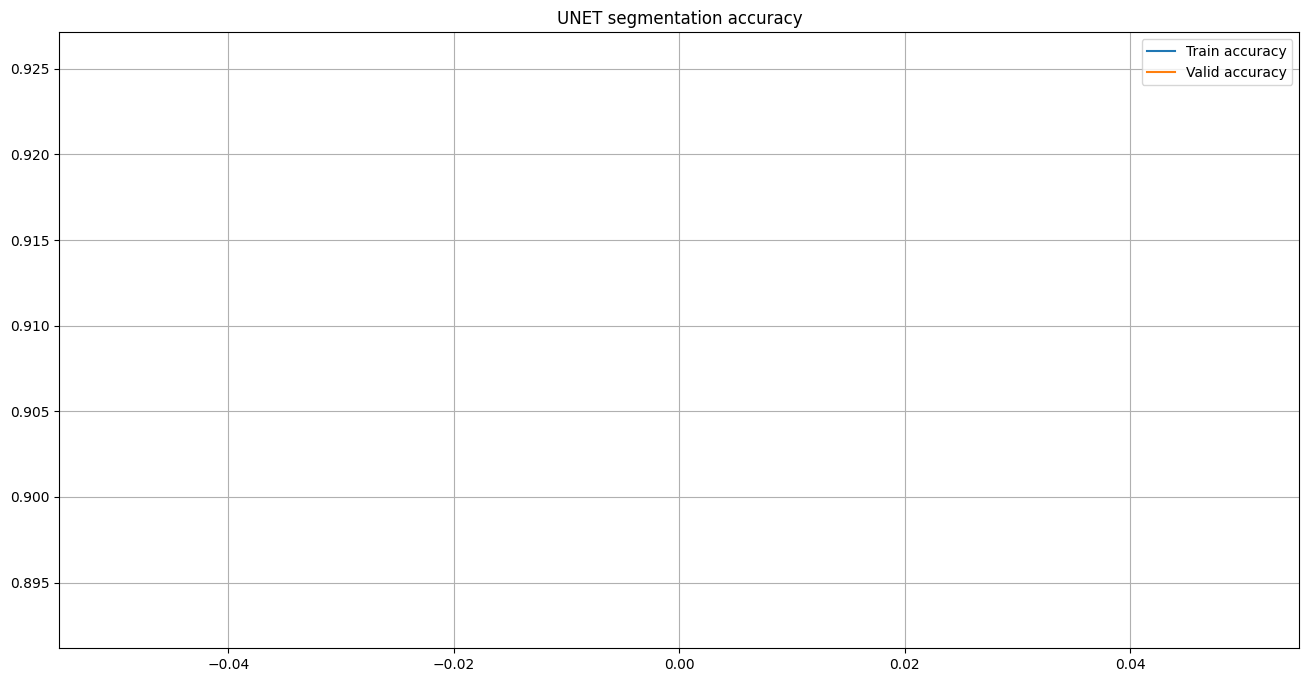

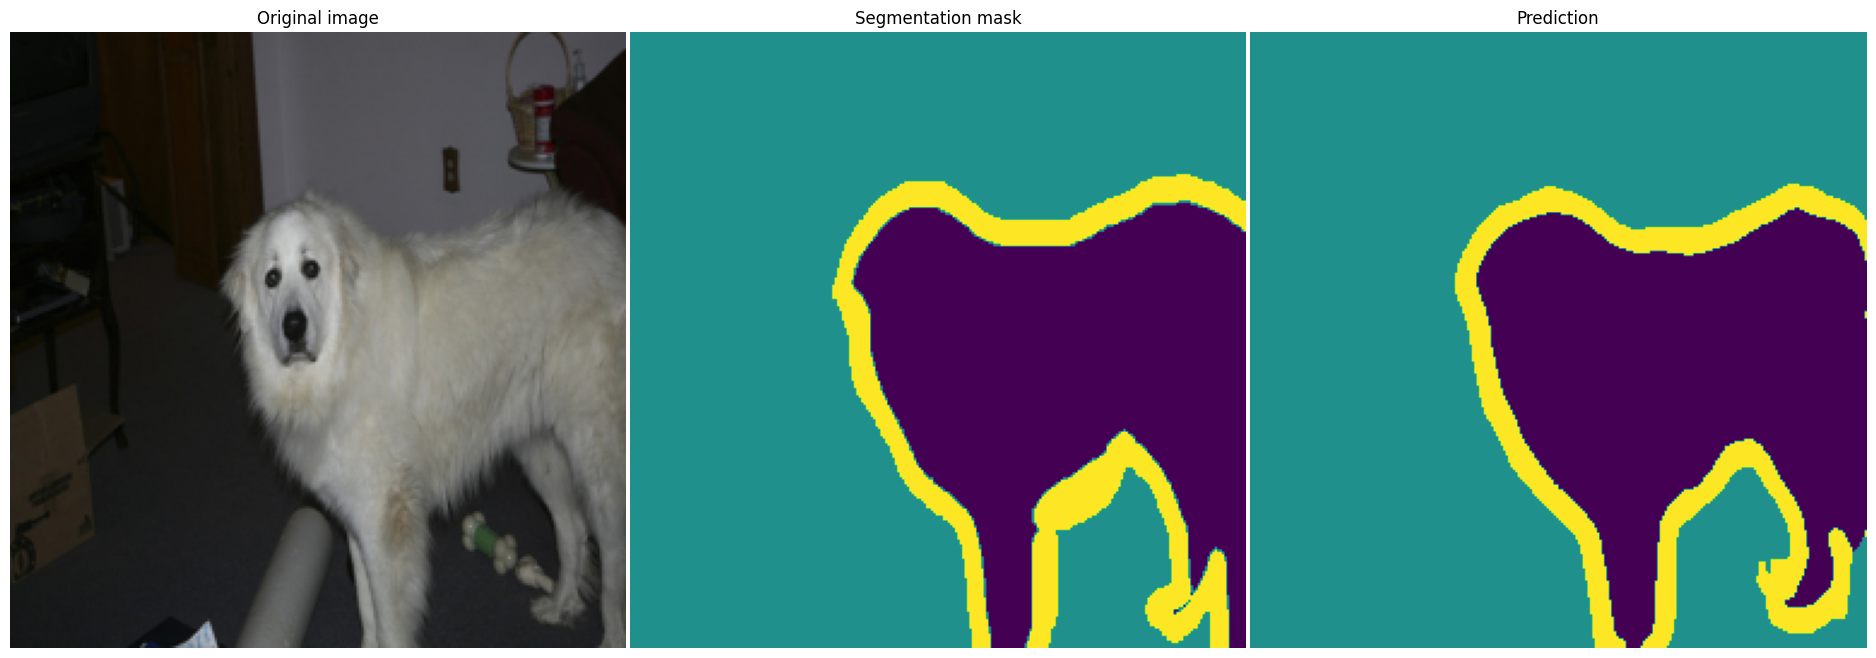

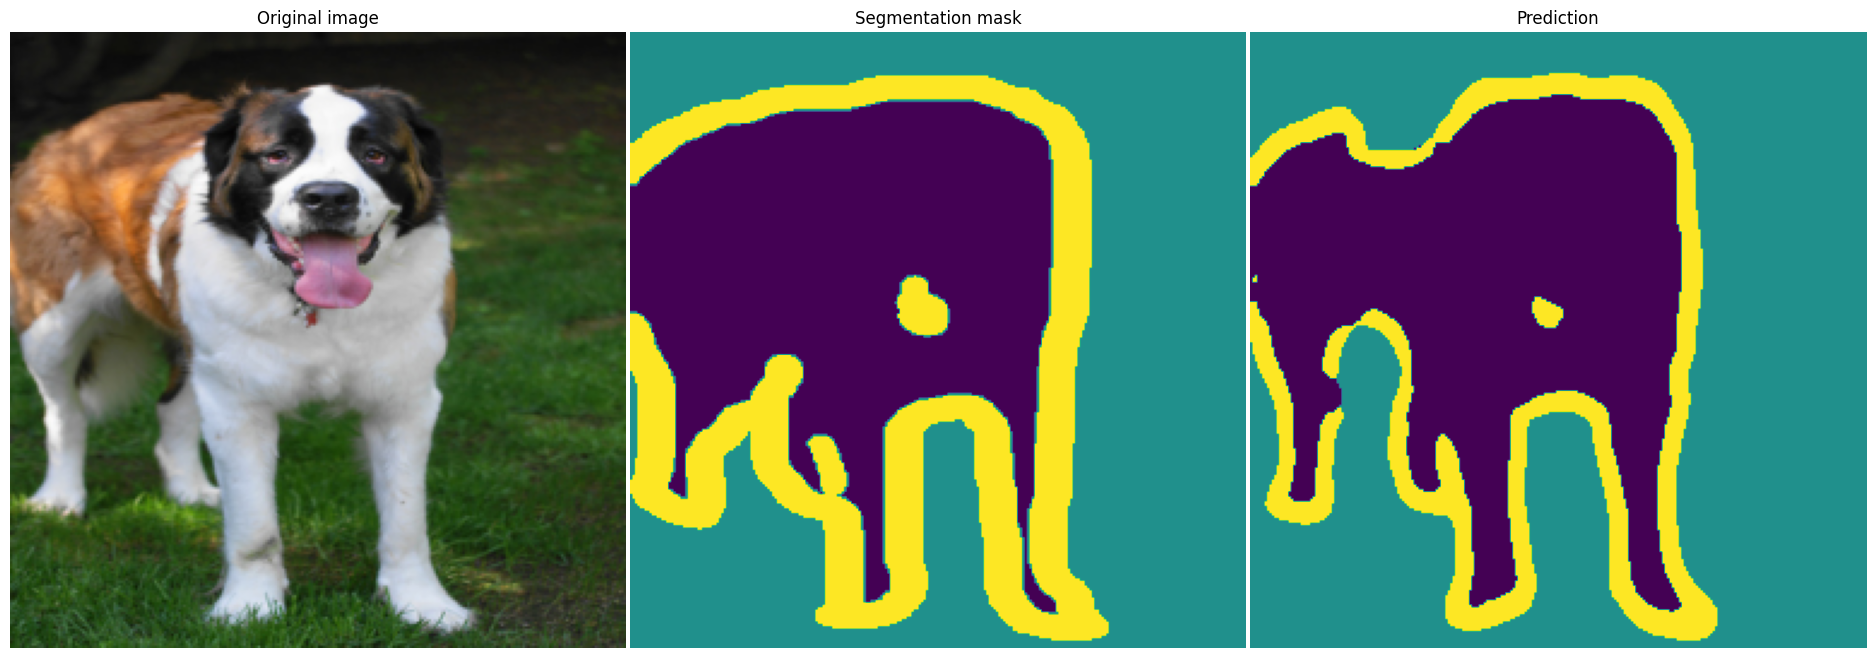

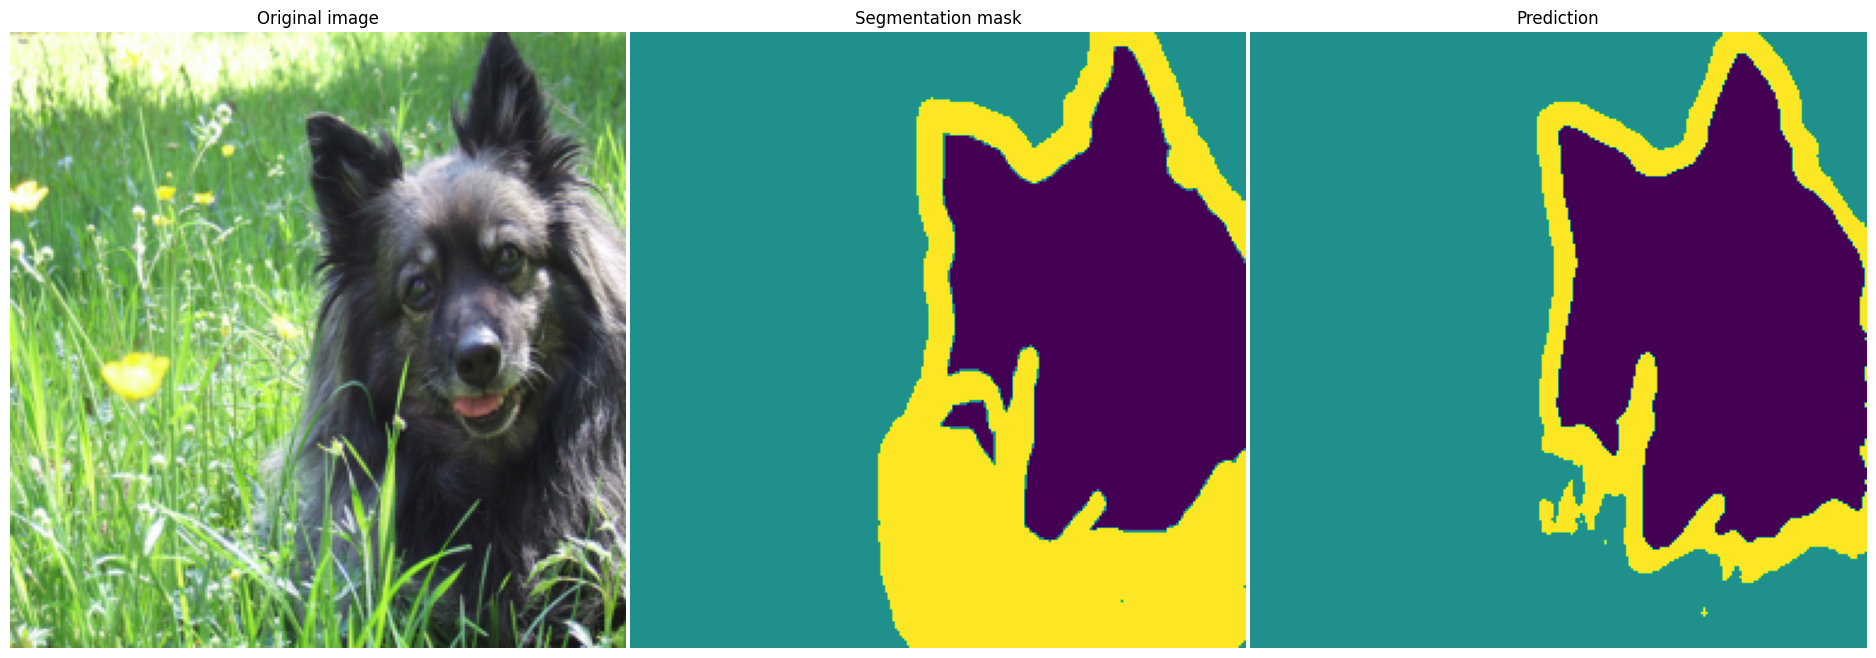

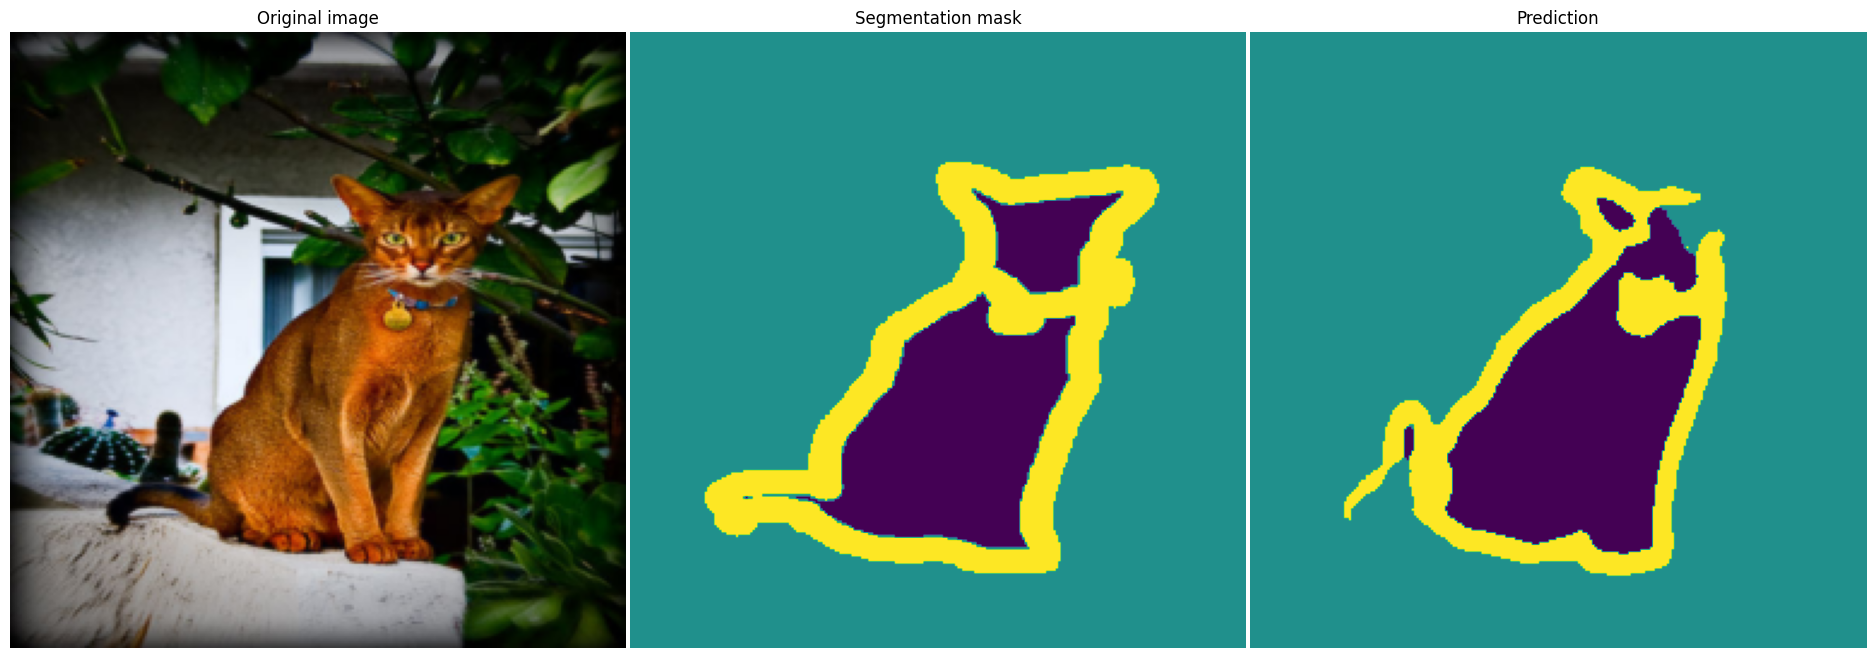

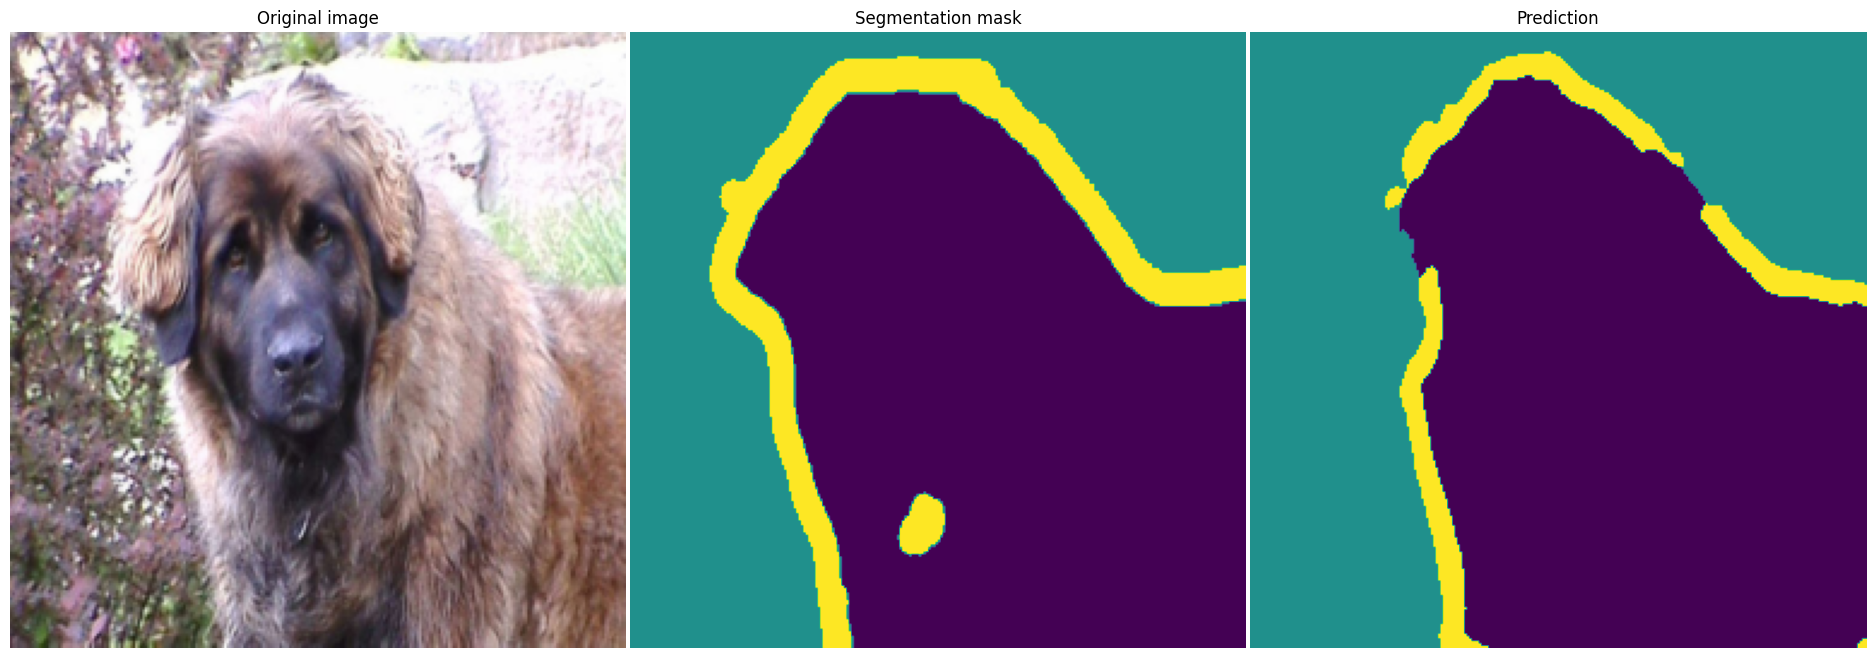

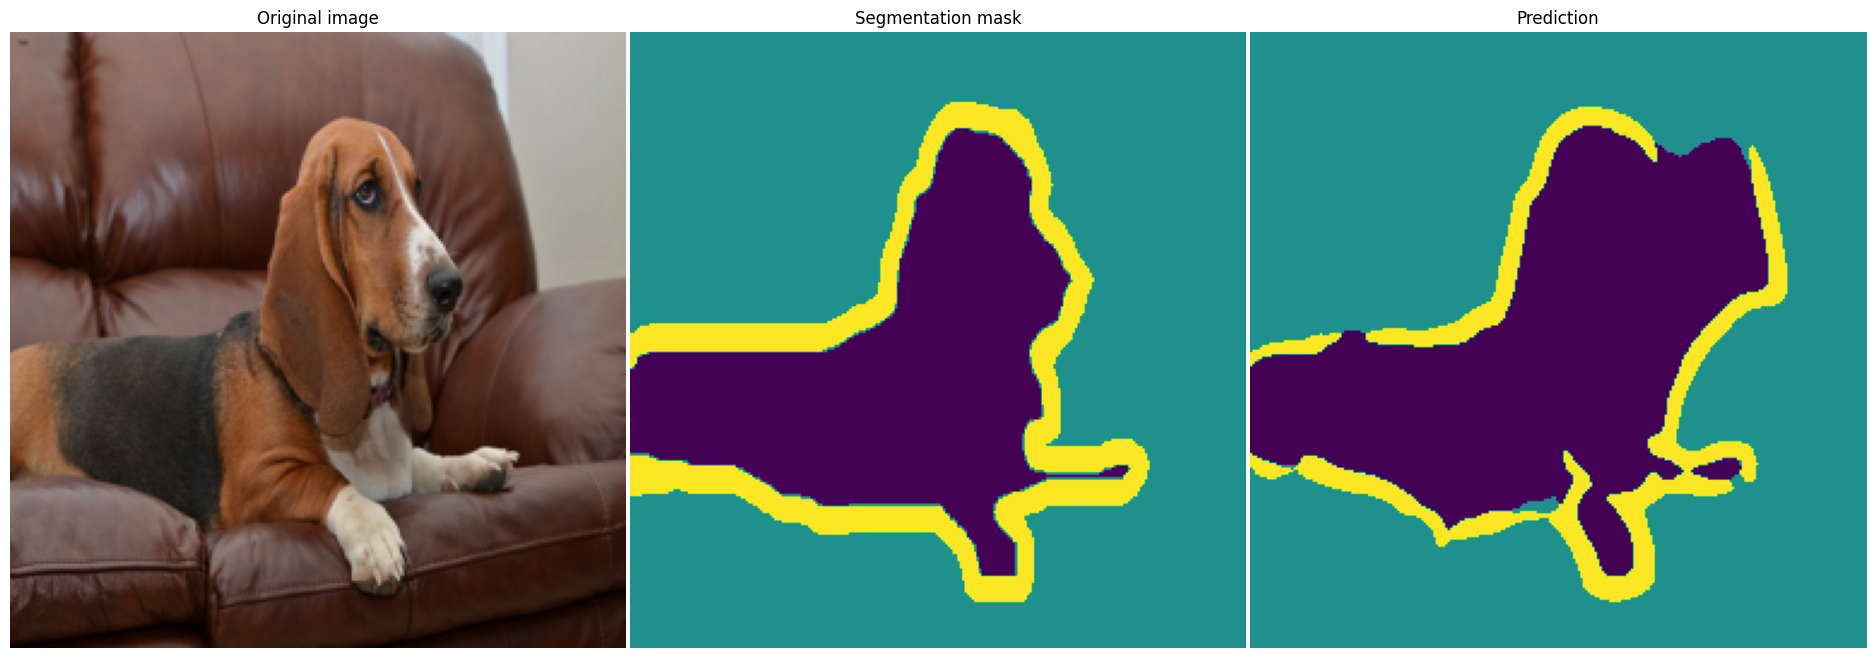

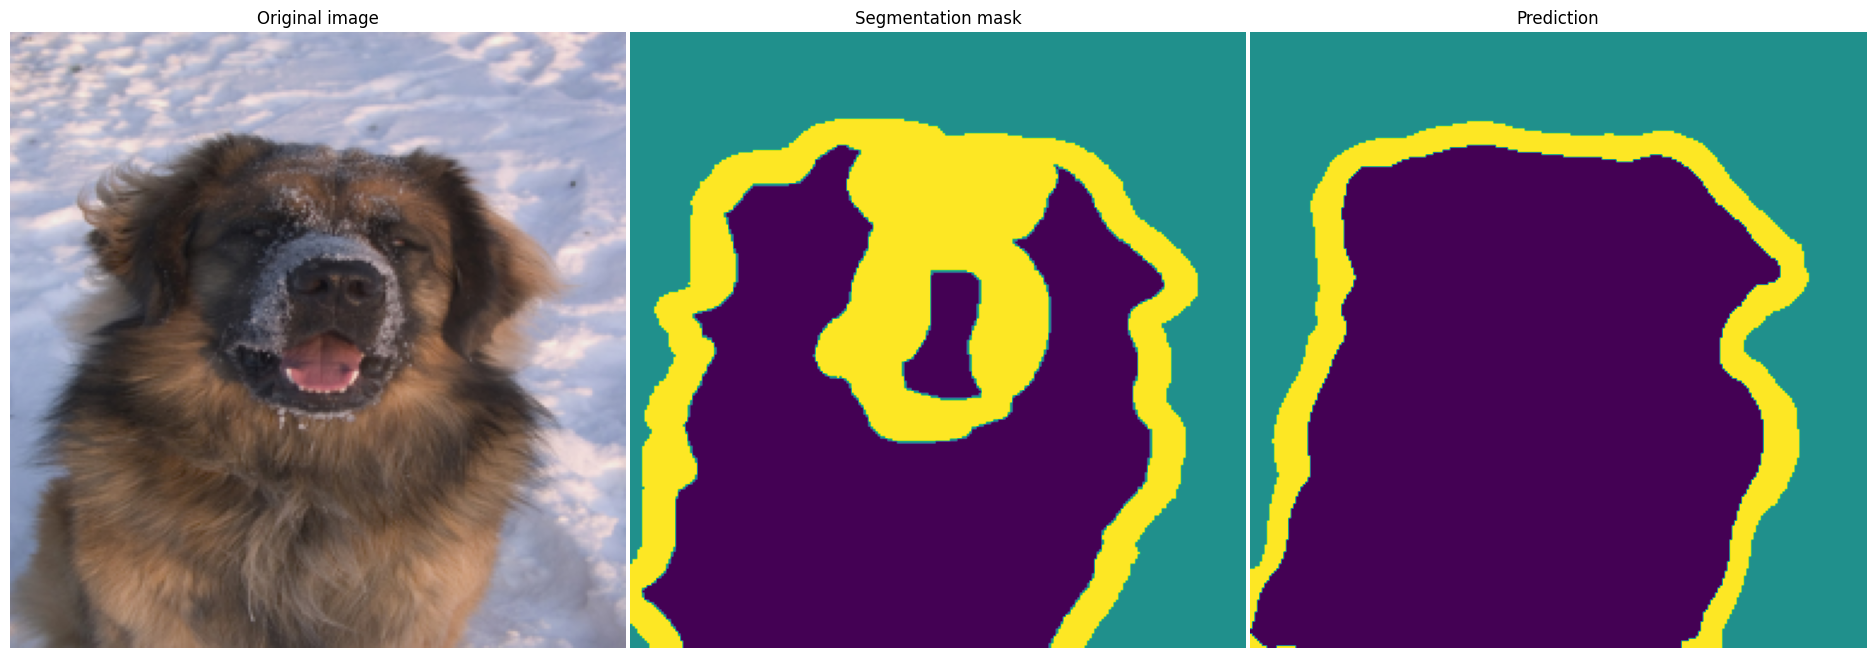

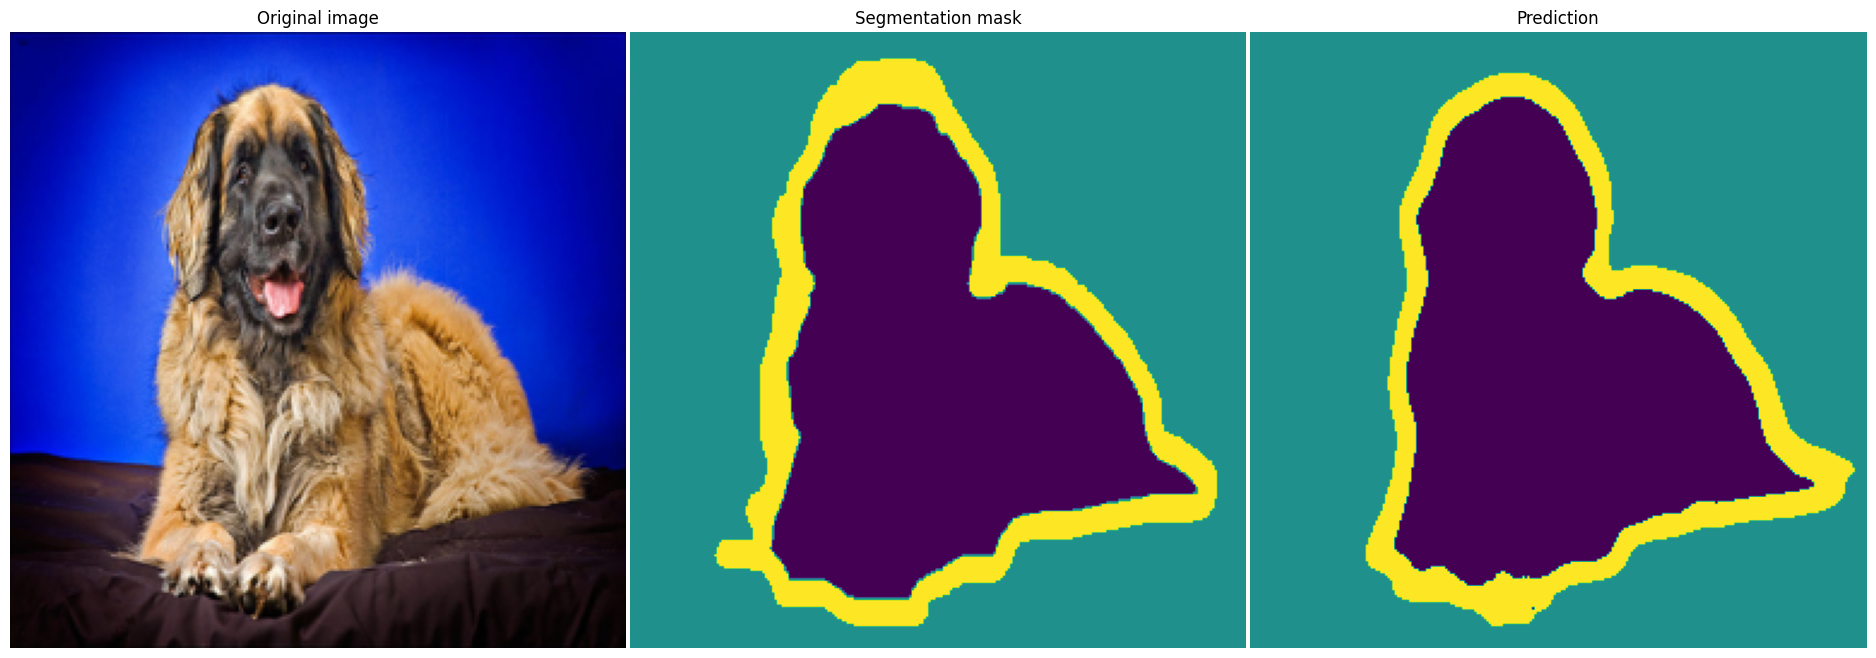

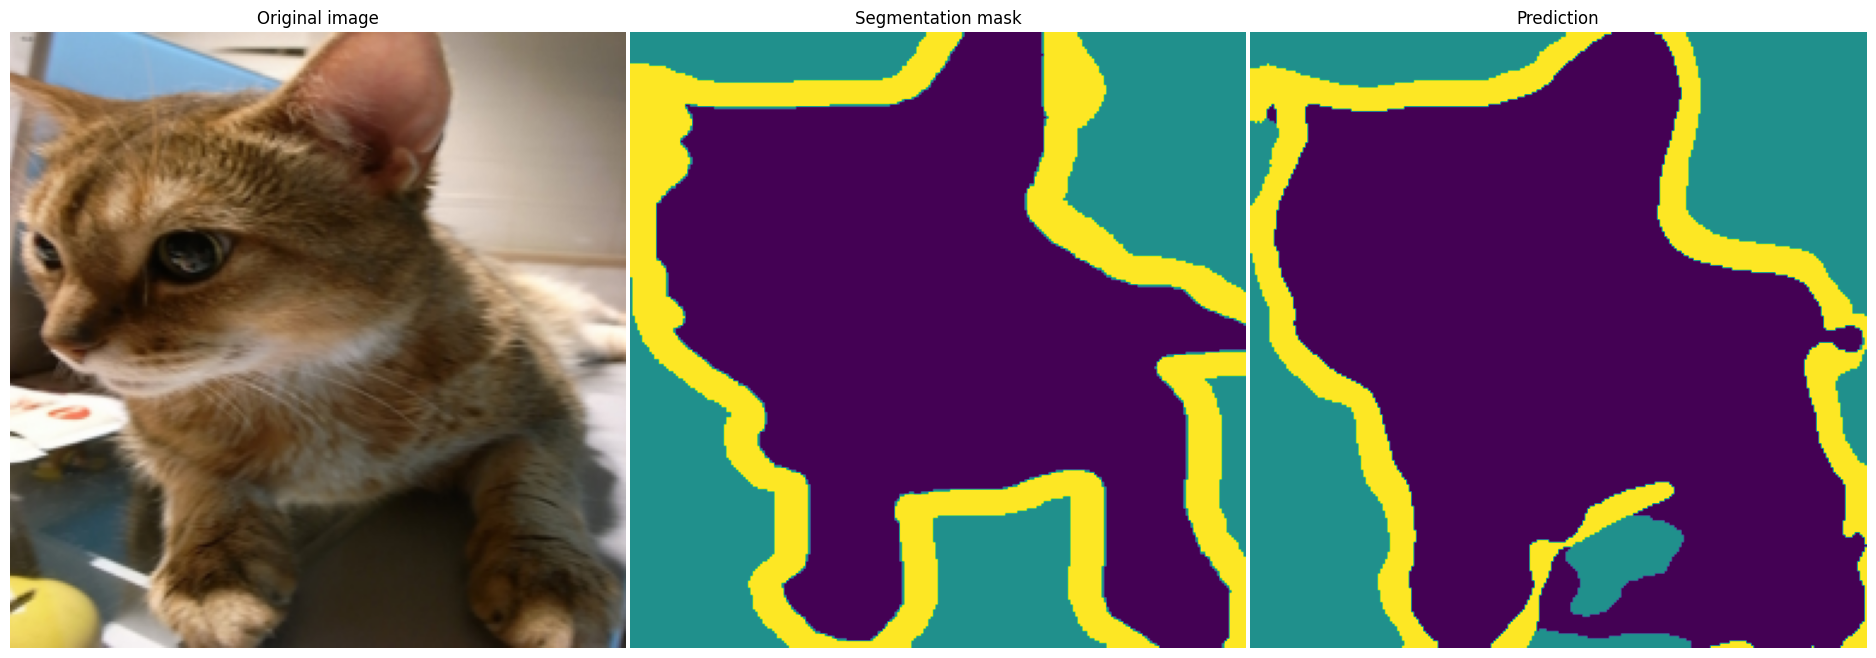

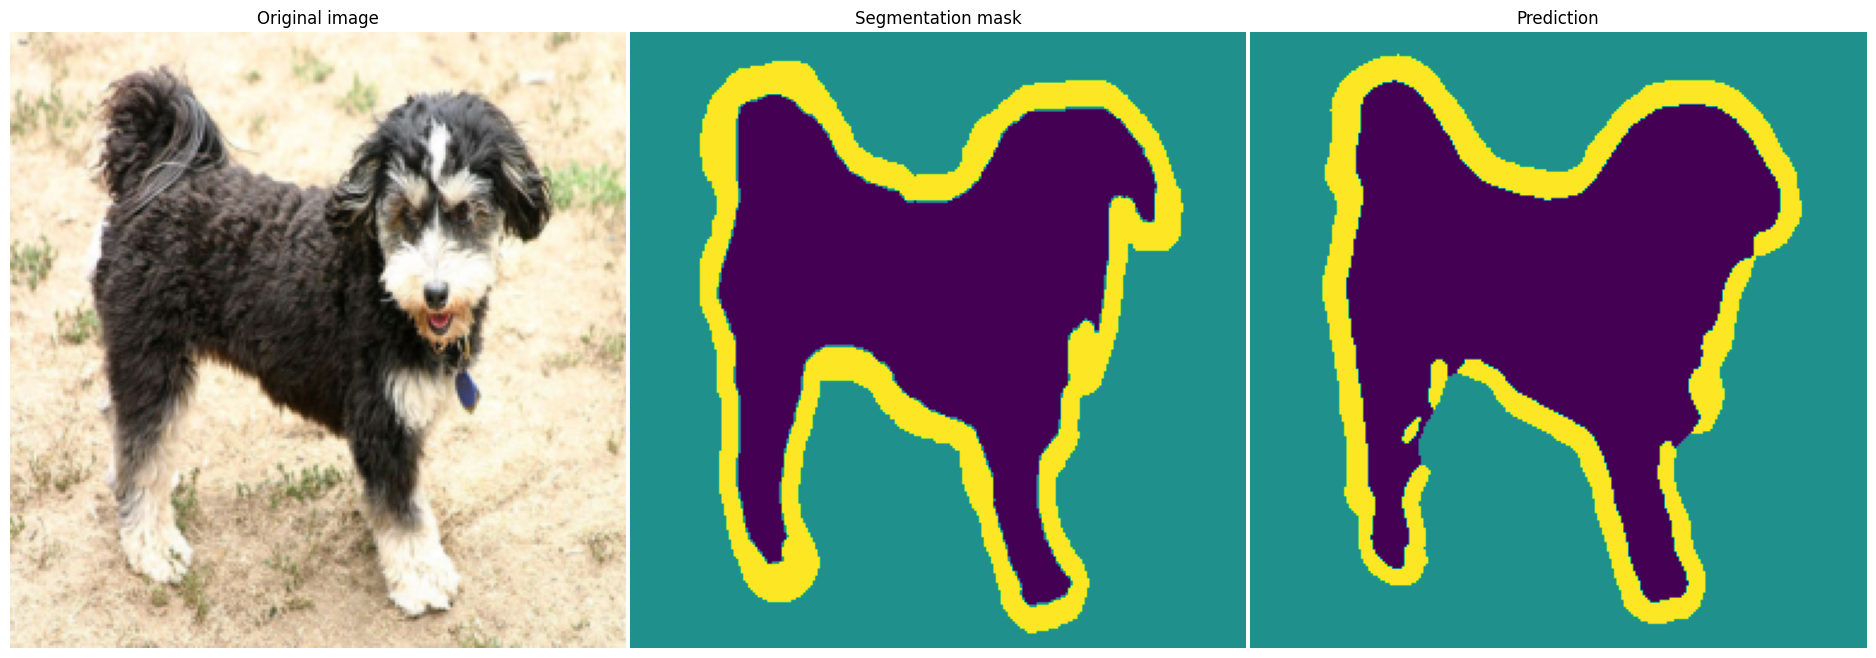

In [18]:
torch.cuda.empty_cache()
whole_train_valid_cycle(model, 40, 'UNET segmentation')

In [19]:
from torch.utils.data import Subset

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

subset = Subset(valid_dataset, idx)

In [20]:
torch.save(model, "/kaggle/working/model")

In [24]:
from torch.utils.data import DataLoader

@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    
    predictions = []

    for x,_ in loader:

        x = x.to(device)

        output = model(x).cpu()

        predictions.append(torch.argmax(output, dim=1))

    conc = torch.cat(predictions)

    return conc

In [25]:
predictions = predict(model,valid_loader, "cuda")


In [28]:
predictions.to(torch.uint8)

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        ...,

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1,

In [30]:
torch.save(predictions.to(torch.uint8).reshape([200, 1, 256, 256]), "/kaggle/working/predictions3.pt")